# Измерение риска инвестирования

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Располагаемые данные. Анализируемый период - 20 лет.

In [2]:
df = pd.read_csv('../data/LKOH_quotes.csv')

# Оценка реального и нормального распределения доходностей
### Доходность год к году

In [3]:
df['yield'] = df['c'].pct_change() * 100
df.loc[:, ['o', 'c', 'time','yield']] # 'o' - цена открытия, 'c' - цена закрытия

,o,c,time,yield
0,398.01,357.00,2000-06-01T07:00:00Z,NaN
1,380.00,350.00,2001-06-01T07:00:00Z,-1.960784
2,556.34,510.00,2002-06-01T07:00:00Z,45.714286
3,562.95,599.92,2003-06-01T07:00:00Z,17.631373
4,802.00,760.66,2004-06-01T07:00:00Z,26.793572
5,984.00,1053.63,2005-06-01T07:00:00Z,38.515237
6,2100.00,2229.04,2006-06-01T07:00:00Z,111.558137
7,1965.00,1969.62,2007-06-01T07:00:00Z,-11.638194
8,2645.00,2318.01,2008-06-01T07:00:00Z,17.688184
9,1680.00,1379.48,2009-06-01T07:00:00Z,-40.488609


### Мат. ожидание

In [4]:
mu = df['yield'].mean()

### Дисперсия и Стандартное отклонение

In [5]:
dispersion = df['yield'].var()
sigma = sqrt(dispersion)

### Коэф. асимметрии и коэф. эксцесса

In [6]:
skew = df['yield'].skew()
kurtosis = df['yield'].kurt()

## Сравнение реального и нормального распределения доходностей

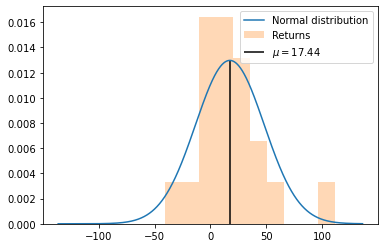

In [7]:
mn = mu - 5 * sigma 
xs = sorted(np.arange(mn, -mn, .05))
ys = [norm.pdf(x, mu, sigma) for x in xs]
h = sorted(np.asarray(df['yield'].dropna()))
plt.plot(xs, ys, label='Normal distribution')
plt.vlines(mu, 0, max(ys), label=f'$\mu = {mu:.2f}$')
plt.hist(h, density=True, histtype='stepfilled', alpha=0.3, label='Returns')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()

## Расчитаем вероятность получения доходности в заданных пределах

In [8]:
def calc_returns(mu, sigma, i):
    dt = mu - sigma*(i+1)
    dt2 = mu + sigma*(i+1)
    if dt > -100:
        return (
            {'dt':dt}, 
            {'dt2': dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )
    else: 
        return (
            {'dt':-100}, 
            {'dt2':dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )

lst = [calc_returns(mu, sigma, i) for i in range(3)]

In [9]:
ll = [f'\nProbability={i[2]["probability"]:.2%} for values: {i[0]["dt"]:.2f} and {i[1]["dt2"]:.2f}' for i in lst]
print(
    f'\nmu={mu:.2f}', 
    f'\nsigma={sigma:.2f}', 
    f'\nskew={skew:.2f}', 
    f'\nkurtosis={kurtosis:.2f}'
)
print(*ll)
print(f'Bankrupt risk={norm.cdf(-100, mu, sigma):.9%}')


mu=17.44 
sigma=30.75 
skew=1.32 
kurtosis=4.06

Probability=68.27% for values: -13.31 and 48.19 
Probability=95.45% for values: -44.06 and 78.94 
Probability=99.73% for values: -74.81 and 109.69
Bankrupt risk=0.006696215%


## Расчитаем изменение годовой доходности на различных временных интервалах

In [10]:
def calc_period(year):
    if year == 1:
        return df['yield'].max(), df['yield'].mean(), df['yield'].min() 
    p_df = pd.DataFrame()
    length = len(df)
    n = 0
    for i in range(length):
        while i+year < length:
            start_price = df.loc[i,'c']
            end_price = df.loc[i+year,'c']
            p_df.loc[i+n,'c'] = start_price
            p_df.loc[i+n+1,'c'] = end_price
            # среднегодовая доходность
            p_df.loc[i+n+1,'yield'] = (pow((end_price/start_price), 1/(year+1)) - 1)*100 
            n += year
            break
    return  p_df['yield'].max(), p_df['yield'].mean(), p_df['yield'].min()
    

In [11]:
tbl_constr = {
    'Annual percentage yield': ['Max', 'Mean', 'Min'], 
    '1 year': calc_period(1),
    '3 years': calc_period(3),
    '5 years': calc_period(5),
    '7 years': calc_period(7),
    '10 years': calc_period(10)
}
tbl_df = pd.DataFrame(data=tbl_constr)
tbl_df

,Annual percentage yield,1 year,3 years,5 years,7 years,10 years
0,Max,111.558137,38.837291,36.147071,26.657499,16.166356
1,Mean,17.441331,11.550857,11.686469,10.499412,9.458514
2,Min,-40.488609,-11.304949,-3.445818,-2.117963,1.302361


## Построим диаграмму годовой доходности на различных временных интервалах

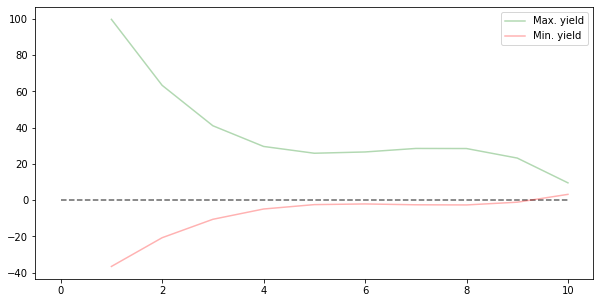

In [12]:
xs = sorted(np.arange(1, 11, 1))
ys_max = [calc_period(x)[0] for x in xs]
ys_min = [calc_period(x)[2] for x in xs]

from scipy.interpolate import splrep, splev

bspl_max = splrep(xs, ys_max, s=1000)
bspl_y_max = splev(xs, bspl_max)

bspl_min = splrep(xs, ys_min, s=1000)
bspl_y_min = splev(xs, bspl_min)

plt.plot(xs, bspl_y_max, label='Max. yield', alpha=0.3, color='green')
plt.plot(xs, bspl_y_min, label='Min. yield', alpha=0.3, color='red')
plt.hlines(0, 0, 10, label=f'', alpha=0.6, linestyle='--')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()

## Интерпретация полученных результатов

**Важно:** Анализ не учитывает дивиденды, ориентируюсь только на рыночную стоимость акций. 

Среднегодовая доходность по акциям составляет 17.44%, волатильность - 30.75%.

Вероятность, в течении года, получить доходность (убыток) в интервале (-13.31%, 48.19%) составляет 68.27%, в интервале (-44.06%, 78.9%) составляет 95.45% и в интервале (-74.81%, 109.69%) составляет 99.73%. Вероятность технического банкротства 0.006696215%. В течении года можно наблюдать просадки более 70%, нужно быть к этому психологически готовым, но так же важно понимать, что акция уже потеряла 30% с начала кризиса.

Представленный график сравнения нормального и реального распределения доходности позволяет утверждать, что реальное распределение достаточно отдален. С одной стороны это показывает на отсутствие "зрелости" акции, с другой стороны, существенная правосторонняя асимметрия (1.32) увеличивает вероятность получения более высоких доходностей, чем это показывает нормальное распределение. Так же мы наблюдаем значительное занижение вершины нормального распределения, что подтверждает коэффициент эксцесса (4.06). В данном случае это играет в пользу Лукойла относительно других нефтяников. Например коэф. эксцесса Роснефть - (0.15), Татнефть - (2.81).

Анализ диаграммы годовой доходности на различных временных интервалах показывает, что инвестирование сроком более чем на 4 года почти выводит минимальную доходность в зону положительных значений, что указывает на ориентировочный горизонт инвестирования.

